# Finance Sentiment Analysis Project using Reddit 

- Predicting stock prices using data from reddit on the r/wallstreetbets subreddit
- Data courtesy of Gabriel Preda on Kaggle

Stock prices at the lowest level, are reflections of investors thoughts on if a company has the potential to grow or not. I wanted to investigate the potential relationship between investor sentiment on reddit and the price of a stock.

In [4]:
!which python

/opt/anaconda3/bin/python


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from wordcloud import WordCloud
from datetime import date
import string

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gakuueno/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gakuueno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/gakuueno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/gakuueno/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/gakuueno/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Loading in the Dataset

In [6]:
reddit_data = pd.read_csv('../data/reddit_wsb.csv')
reddit_data.head(5)

title  ...            timestamp
0  It's not about the money, it's about sending a...  ...  2021-01-28 21:37:41
1  Math Professor Scott Steiner says the numbers ...  ...  2021-01-28 21:32:10
2                                    Exit the system  ...  2021-01-28 21:30:35
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...  ...  2021-01-28 21:28:57
4  Not to distract from GME, just thought our AMC...  ...  2021-01-28 21:26:56

[5 rows x 8 columns]

# EDA and getting to know the dataset

In [7]:
print(reddit_data.columns)
print(reddit_data.shape)
print(reddit_data.dtypes)
print(reddit_data.describe())

Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')
(53187, 8)
title         object
score          int64
id            object
url           object
comms_num      int64
created      float64
body          object
timestamp     object
dtype: object
               score     comms_num       created
count   53187.000000  53187.000000  5.318700e+04
mean     1382.461053    263.260252  1.614582e+09
std      7999.271074   2532.665113  4.173566e+06
min         0.000000      0.000000  1.601340e+09
25%         2.000000      3.000000  1.611882e+09
50%        37.000000     17.000000  1.612488e+09
75%       207.000000     60.000000  1.615347e+09
max    348241.000000  93268.000000  1.629095e+09


In [8]:
# Distribution of post lengths

reddit_data['post_length'] = reddit_data['title'].apply(lambda post: len(post))
post_len_dist = px.histogram(reddit_data, x = 'post_length', nbins = 10)
post_len_dist.update_layout(template="plotly_dark")
post_len_dist.show()

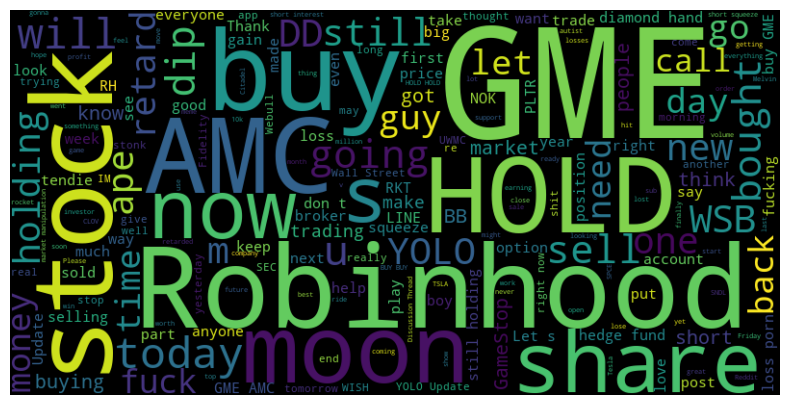

In [9]:
#Most commonly mentioned words in the data

posts = ' '.join(reddit_data['title'].values)

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(posts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
reddit_data['timestamp'] = pd.to_datetime(reddit_data['timestamp']).apply(lambda timestamp: timestamp.date())

dates = px.scatter(reddit_data, x = 'timestamp', y = [1] * reddit_data.shape[0])
dates.update_layout(template="plotly_dark")
dates.show()


In [11]:
reddit_data = reddit_data.sort_values(by = 'timestamp', ascending = True).loc[1:].reset_index(drop = True)

In [12]:
date_post_count_data = reddit_data.groupby('timestamp').count().reset_index()

date_post_count_plot = px.scatter(date_post_count_data, x = 'timestamp', y = 'title')
date_post_count_plot.add_scatter(x=date_post_count_data['timestamp'], y=date_post_count_data['title'], mode='lines', name='Line')
date_post_count_plot.update_layout(template="plotly_dark")
date_post_count_plot.show()

## Why was there a spike in post counts in January 29, 2021?

January 29th 2021 aligns with the date individual investors bought on mass gamestop stock. Since the movement initally began on the subreddit thread wallstreetbets, this explains the spike in posts that day.

In [13]:
#Checking if any of the posts have any nan values
reddit_data['title'].isna().sum()

0

In [14]:
#combining title and post into one text column

reddit_data['body'].fillna("", inplace = True)
reddit_data['text'] = reddit_data['title'] + " " + reddit_data['body']

# Sentiment Analysis
## Data Preprocessing

In [15]:
#combining title and post into one text column

reddit_data['body'].fillna("", inplace = True)
reddit_data['text'] = reddit_data['title'] + " " + reddit_data['body']

In [16]:
sia = SentimentIntensityAnalyzer()
reddit_data['sentiment_score'] = reddit_data['text'].apply(lambda text: sia.polarity_scores(text)['compound'])
reddit_data.head(5)

title  ...  sentiment_score
0  Math Professor Scott Steiner says the numbers ...  ...          -0.7034
1                                   Robinhood update  ...           0.0000
2                       420 wasn’t a meme. GME 🚀 🚀 🚀  ...           0.0000
3                           Before you sleep tonight  ...           0.7685
4                        To The Mass Relays & Beyond  ...           0.0000

[5 rows x 11 columns]

In [17]:
print(reddit_data['sentiment_score'].describe())

count    52386.000000
mean         0.154606
std          0.550879
min         -0.999900
25%         -0.128000
50%          0.000000
75%          0.624900
max          1.000000
Name: sentiment_score, dtype: float64


In [18]:
seniment_box = px.box(reddit_data, x = 'sentiment_score')
seniment_box.update_layout(template='plotly_dark')

In [19]:
sentiment_dist = px.histogram(reddit_data, x = 'sentiment_score', nbins = 10)
sentiment_dist.update_layout(template='plotly_dark')

In [20]:
# Divide the dataset into positives and negatives to see what sort of differences are there between them
pos_sentiment = reddit_data[reddit_data['sentiment_score'] > 0.25]
neg_sentiment = reddit_data[reddit_data['sentiment_score'] < -0.25]


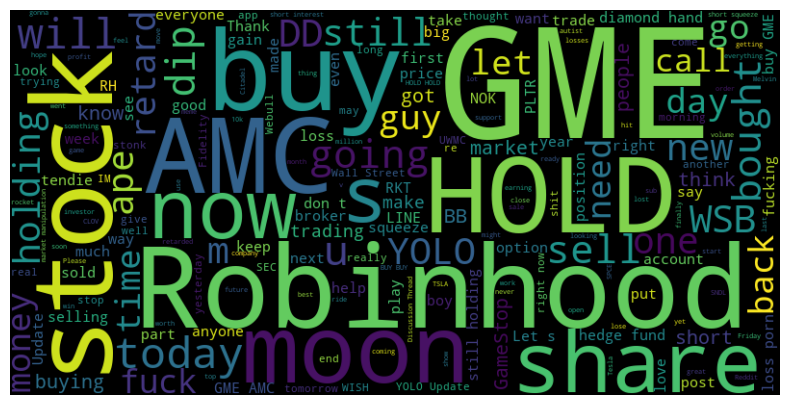

In [21]:
#Most commonly mentioned words in posts with positive sentiment
posts = ' '.join(pos_sentiment['text'].values)

pos_sent_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(posts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

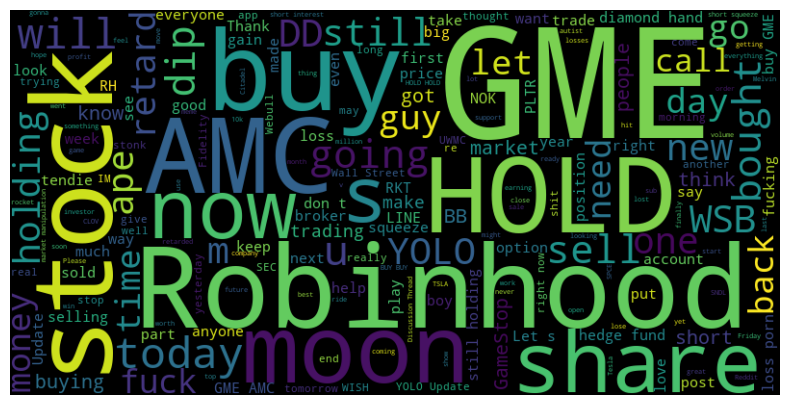

In [22]:
#Most commonly mentioned words in posts with negative sentiment
posts = ' '.join(neg_sentiment['text'].values)

neg_sent_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(posts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Giving a glance at the words, it does not seem like there is a lot in common between posts with postive and negative sentiment.

In [23]:
# Change in sentiment over time
day_agg = reddit_data.groupby('timestamp').mean(numeric_only =True).reset_index()
day_agg

timestamp        score  ...  post_length  sentiment_score
0    2021-01-28   687.659950  ...    57.617128        -0.024413
1    2021-01-29   408.457309  ...    54.970817        -0.008826
2    2021-01-30  4618.594101  ...    66.883427         0.152962
3    2021-01-31  5230.513312  ...    69.379127         0.163455
4    2021-02-01  4230.302036  ...    71.330317         0.169128
..          ...          ...  ...          ...              ...
171  2021-08-12   647.386667  ...    49.453333         0.377009
172  2021-08-13   773.593750  ...    46.937500         0.295266
173  2021-08-14  1204.837838  ...    52.972973         0.275024
174  2021-08-15  1210.619048  ...    49.761905         0.628829
175  2021-08-16    66.090909  ...    51.818182         0.717727

[176 rows x 6 columns]

In [24]:
avg_scores_overtime = px.scatter(day_agg, x = 'timestamp', y = 'sentiment_score')

avg_scores_overtime.update_layout(template="plotly_dark", yaxis_title = "average sentiment score each day")
avg_scores_overtime.show()

# Financial Data
- For this project, I will be mostly evaluating the performance of sentiment vs the performance of the market as a whole. I will be using the S&P 500 as the metric of the general market, using data from yfinance.
- I am going to try to figure out if there is any predictive power in sentiment of the reddit posts in the price of the s&p the following day.

In [25]:
import yfinance as yf

In [35]:
sp_500_ticker = yf.Ticker('VOO')

start_date = day_agg['timestamp'].iloc[0]
end_date = day_agg['timestamp'].iloc[-1]

sp_500_data = sp_500_ticker.history(start = start_date, end = end_date)
sp_500_data.index = sp_500_data.index.date
sp_500_data['returns'] = sp_500_data['Close'].pct_change()
sp_500_data = sp_500_data.reset_index(names = 'timestamp')
score_returns = day_agg[['timestamp', 'sentiment_score']].merge( \
    sp_500_data[['timestamp', 'Close', 'returns']], on = 'timestamp', how = 'inner')
score_returns['returns'] = score_returns['returns'].shift(-1)
score_returns = score_returns.iloc[:-1]
score_returns


timestamp  sentiment_score       Close   returns
0    2021-01-28        -0.024413  327.084839 -0.020021
1    2021-01-29        -0.008826  320.536133  0.016433
2    2021-02-01         0.169128  325.803375  0.014374
3    2021-02-02         0.100040  330.486389  0.000998
4    2021-02-03         0.090118  330.816193  0.011194
..          ...              ...         ...       ...
115  2021-08-06         0.389538  386.022491 -0.000959
116  2021-08-09         0.276269  385.652466  0.001255
117  2021-08-10         0.224926  386.136383  0.002408
118  2021-08-11         0.426276  387.066162  0.002917
119  2021-08-12         0.377009  388.195190  0.001980

[120 rows x 4 columns]

In [36]:
sentiment_returns_scatter = px.scatter(score_returns, x='sentiment_score', y='returns')
sentiment_returns_scatter.update_layout(template="plotly_dark")
sentiment_returns_scatter.show()

# Analysis
- Looking at the plot of returns vs sentiment, at first glance, there is close to 0 corrlation between the returns of a stock and the sentiment score of the reddit posts. However, I would still like to quantify this relationship even if there is none.

In [37]:
import statsmodels.api as sm

X = score_returns['sentiment_score']
y = score_returns['returns']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8694
Date:                Tue, 24 Dec 2024   Prob (F-statistic):              0.353
Time:                        16:52:03   Log-Likelihood:                 406.81
No. Observations:                 120   AIC:                            -809.6
Df Residuals:                     118   BIC:                            -804.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0033      0.002     

## Analysis of OLS Regression Results
- The $R^2$ term for this regression is 0.007, which means that only around 0.7% of the variance in the returns of the S&P can be explained by the change in sentiment in the reddit posts. Indicating a minute correlation between the two variables. 
- Looking at the correlation term, there is a slight positive relationship between the two variables. However, with a t-statistic of 1.448, we cannot reject the null hypothesis that there is no relationship at the 95% level.
    - This means that there is no statistical siginificance in the coefficient that was already, very small